## Bank Customer Segmentation

### 1.1 Importing Libraries

In [118]:
import numpy as np 
import pandas as pd
import re
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn. preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
import plotly.graph_objects as go
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)    

### 1.2 Loading and Interpreting data 

In [119]:
bank_transaction_df=pd.read_csv("/kaggle/input/bank-transactions/bank_transactions.csv")
bank_transaction_df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [120]:
bank_transaction_df.shape

(1048567, 9)

##### The data consists of 1048567 rows and 9 columns

### 1.3 Data Cleaning

In [121]:
bank_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [122]:
## Show number of unique rows and sum of null records
def transaction_information_check(df):
    lst=[]
    for col in df.columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        lst.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(lst)
    df_check.columns=['column_name','data types','nunique','num of sum null']
    return df_check 
transaction_information_check(bank_transaction_df)

,column_name,data types,nunique,num of sum null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


#### Fields Customer DOB , Cust Gender, Cust Location, Cust Account Balance contains Null values.
#### As the number of null records is comparitively very less, we can drop the null records.  
#### The number of unique values for customer gender is 3.
#### The dataframe is having data grain of transaction id. The data in dataframe is based on unique transaction id.

In [123]:
# Convert columns Transaction Date and Customer DOB from string to datetime
bank_transaction_df['TransactionDate'] = pd.to_datetime(bank_transaction_df['TransactionDate'])
bank_transaction_df['CustomerDOB'] = pd.to_datetime(bank_transaction_df['CustomerDOB'])

/tmp/ipykernel_43/993110334.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_transaction_df['TransactionDate'] = pd.to_datetime(bank_transaction_df['TransactionDate'])
/tmp/ipykernel_43/993110334.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_transaction_df['CustomerDOB'] = pd.to_datetime(bank_transaction_df['CustomerDOB'])


In [124]:
# Deleting missing records
bank_transaction_df.dropna(inplace = True)

In [125]:
#check for duplication
print("The number of duplicate records in dataframe is",bank_transaction_df.duplicated().sum())

The number of duplicate records in dataframe is 0


In [126]:
# checking Customer Gender column unique values
print("The bank transaction data have following number of record count for unique values of Gender") 
bank_transaction_df['CustGender'].value_counts()

The bank transaction data have following number of record count for unique values of Gender


CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [127]:
bank_transaction_df.drop(bank_transaction_df[bank_transaction_df['CustGender']=='T'].index,inplace=True)

In [128]:
# The data type of columns Transaction Date and Customer Date of Birth needs to change from object to date
bank_transaction_df['TransactionDate'] = pd.to_datetime(bank_transaction_df['TransactionDate'])
bank_transaction_df['CustomerDOB'] = pd.to_datetime(bank_transaction_df['CustomerDOB'])

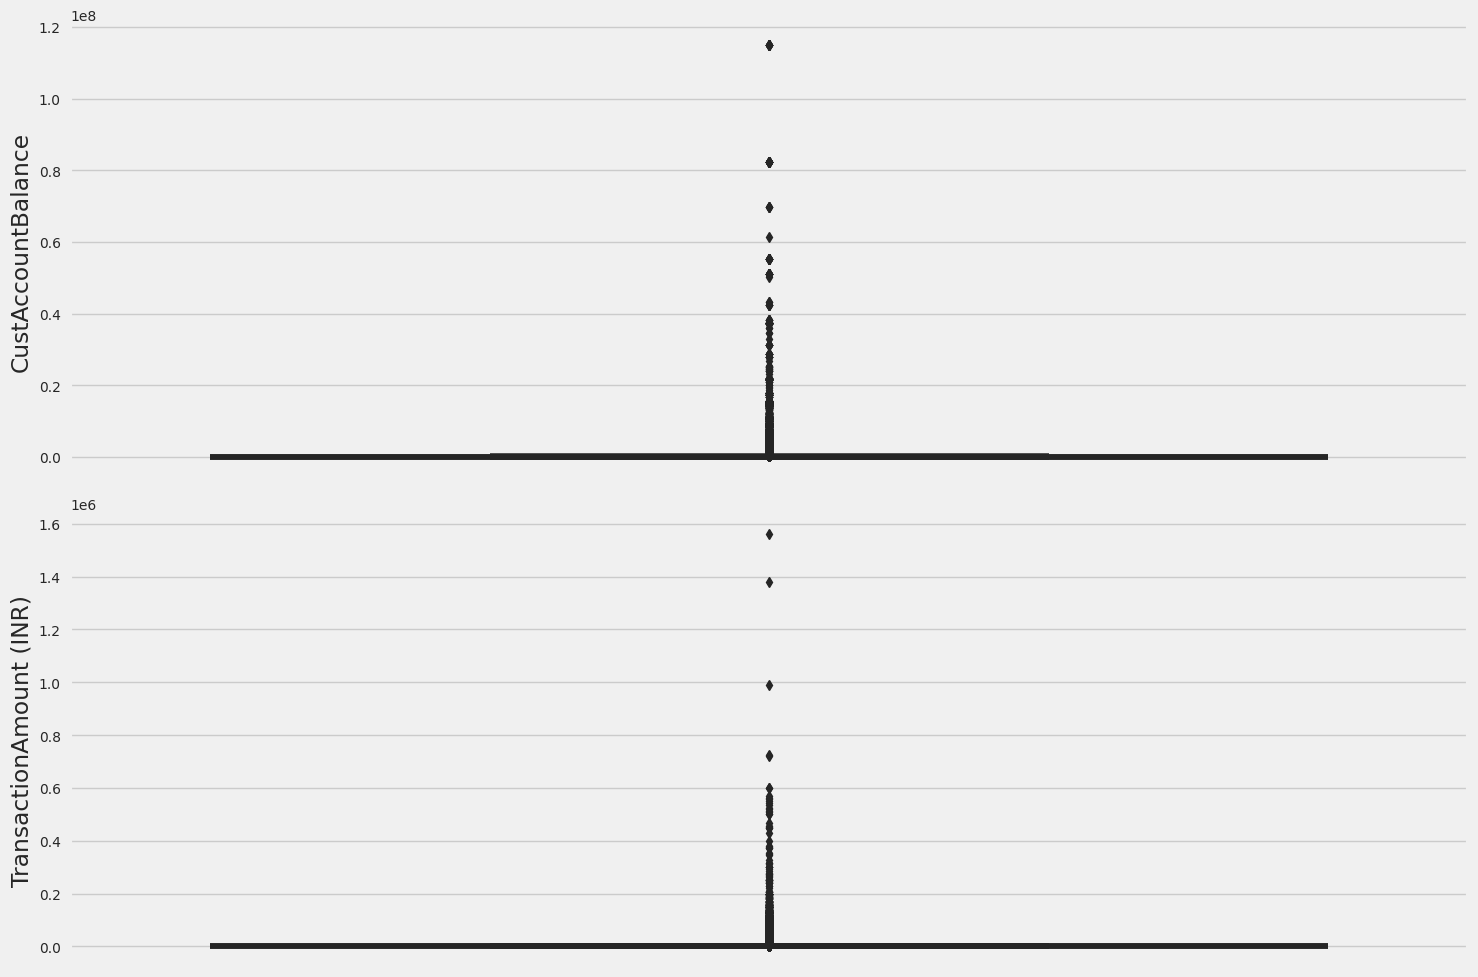

In [129]:
# Visualizing Outliers in Numerical columns
numerical_cols = ['CustAccountBalance','TransactionAmount (INR)']
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
sns.boxplot(data = bank_transaction_df, y = 'CustAccountBalance', ax = ax[0],color = '#004a7a')
sns.boxplot(data = bank_transaction_df, y = 'TransactionAmount (INR)', ax = ax[1],color = '#004a7a')
plt.tight_layout()

#### The box plot reveals that there are many points out of box. These are not outliers and they may represent specific class of customer

### 1.4 Feature Generation

#### RFM Variables (Recency, Frequency and Monetary value)

##### RFM Analysis is a methodology to segment customer based on their behaviour.
##### Recency : How recent customer has done transaction (i.e last transaction date - current date*) . Here I am assuming that I am carrying out this analysis on the last transaction that has occured(max transaction date present in the data). 
##### Frequency : How frequently is customer carrying out the transactions.
##### Monetary : Amount of transaction done by customer.

In [130]:
bank_transaction_df['Analysis_date'] = bank_transaction_df['TransactionDate'].max()

In [131]:
# From Customer DOB, we can generate a new feature of Customer Age.
bank_transaction_df['CustomerAge'] =bank_transaction_df['Analysis_date'].dt.year - bank_transaction_df['CustomerDOB'].dt.year

#### Minimum age of customer to open bank account is 10. Let us look at number of records having customer age<10.

In [132]:
bank_transaction_df[bank_transaction_df['CustomerAge'] < 10].shape[0]

94069

#### There are 84161 records where customer age is less than 10. Looks like the column contains too many incorrect records. It would be better to exclude this column from our analysis

In [133]:
# Recency = Analysis date - Customer Last Transaction date
#Creating Recency Table Strategy

RFM_df = bank_transaction_df.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "TransactionDate":"max",
                                        "Analysis_date":"max"
                        }).reset_index()


RFM_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionDate,Analysis_date
0,C1010011,2,F,NOIDA,76340.635,2553.0,2016-09-26,2016-12-09
1,C1010012,1,M,MUMBAI,24204.490,1499.0,2016-08-14,2016-12-09
2,C1010014,2,F,MUMBAI,100112.950,727.5,2016-07-08,2016-12-09
3,C1010018,1,F,CHAMPARAN,496.180,30.0,2016-09-15,2016-12-09
4,C1010024,1,M,KOLKATA,87058.650,5000.0,2016-08-18,2016-12-09


In [134]:
RFM_df.shape

(879357, 8)

In [135]:
RFM_df["Recency"] = RFM_df["Analysis_date"] - RFM_df["TransactionDate"]

In [136]:
RFM_df.rename(columns={"TransactionID":"Frequency"},inplace = True)

In [137]:
RFM_df['Recency'] = RFM_df['Recency'].astype(str)

In [138]:
RFM_df['Recency'] = RFM_df['Recency'].apply(lambda x: re.search('\d+',x).group())
RFM_df['Recency']= RFM_df['Recency'].astype(int)

In [139]:
RFM_df.head()

,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionDate,Analysis_date,Recency
0,C1010011,2,F,NOIDA,76340.635,2553.0,2016-09-26,2016-12-09,74
1,C1010012,1,M,MUMBAI,24204.490,1499.0,2016-08-14,2016-12-09,117
2,C1010014,2,F,MUMBAI,100112.950,727.5,2016-07-08,2016-12-09,154
3,C1010018,1,F,CHAMPARAN,496.180,30.0,2016-09-15,2016-12-09,85
4,C1010024,1,M,KOLKATA,87058.650,5000.0,2016-08-18,2016-12-09,113


##### Segmenting customers on Frequency, CustAccountBalance, TransactionAmount, Customer Age and Recency

In [140]:
#Calculating outliers for each of above feature
rfm_cols = ['Recency','Frequency','TransactionAmount (INR)','CustAccountBalance']
outlier_df = RFM_df[rfm_cols].quantile(q = [0.25,0.5,0.75]).T
outlier_df.columns = ['Q1','Q2','Q3']
outlier_df['lower_limit'] = outlier_df['Q1'] - 1.5*(outlier_df['Q3'] - outlier_df['Q1'])
outlier_df['upper_limit'] = outlier_df['Q3'] + 1.5*(outlier_df['Q3'] - outlier_df['Q1'])
outlier_df['num_of_outliers'] = ((RFM_df[rfm_cols] < outlier_df['lower_limit']) | (RFM_df[rfm_cols] > outlier_df['upper_limit'])).sum()
outlier_df['percent_outliers(%)'] = round(outlier_df['num_of_outliers']/RFM_df.shape[0] * 100,2)
 
    

In [141]:
outlier_df

,Q1,Q2,Q3,lower_limit,upper_limit,num_of_outliers,percent_outliers(%)
Recency,86.00,109.00,153.00,-14.500,253.500,96016,10.92
Frequency,1.00,1.00,1.00,1.000,1.000,141961,16.14
TransactionAmount (INR),190.87,500.00,1241.00,-1384.325,2816.195,91776,10.44
CustAccountBalance,5591.27,18665.78,61541.97,-78334.780,145468.020,116569,13.26


#### The percentage of outliers for each column is very high. The data points outside lower and upper limit may represent a specific trend. They are not outliers.So its better not to exclude those data points.

In [142]:
RFM_df.head()

,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionDate,Analysis_date,Recency
0,C1010011,2,F,NOIDA,76340.635,2553.0,2016-09-26,2016-12-09,74
1,C1010012,1,M,MUMBAI,24204.490,1499.0,2016-08-14,2016-12-09,117
2,C1010014,2,F,MUMBAI,100112.950,727.5,2016-07-08,2016-12-09,154
3,C1010018,1,F,CHAMPARAN,496.180,30.0,2016-09-15,2016-12-09,85
4,C1010024,1,M,KOLKATA,87058.650,5000.0,2016-08-18,2016-12-09,113


### 1.5 Exploratory Data Analysis (EDA)

In [143]:
RFM_df.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),TransactionDate,Analysis_date,Recency
count,879357.000000,8.793570e+05,8.793570e+05,879357,879357,879357.000000
mean,1.184517,1.147151e+05,1.566759e+03,2016-08-02 04:59:55.738249216,2016-12-09 00:00:00,128.791716
min,1.000000,0.000000e+00,0.000000e+00,2016-01-08 00:00:00,2016-12-09 00:00:00,0.000000
25%,1.000000,5.591270e+03,1.908700e+02,2016-07-09 00:00:00,2016-12-09 00:00:00,86.000000
50%,1.000000,1.866578e+04,5.000000e+02,2016-08-22 00:00:00,2016-12-09 00:00:00,109.000000
75%,1.000000,6.154197e+04,1.241000e+03,2016-09-14 00:00:00,2016-12-09 00:00:00,153.000000
max,6.000000,1.150355e+08,1.560035e+06,2016-12-09 00:00:00,2016-12-09 00:00:00,336.000000
std,0.448954,8.010842e+05,6.433167e+03,NaN,NaN,80.051009


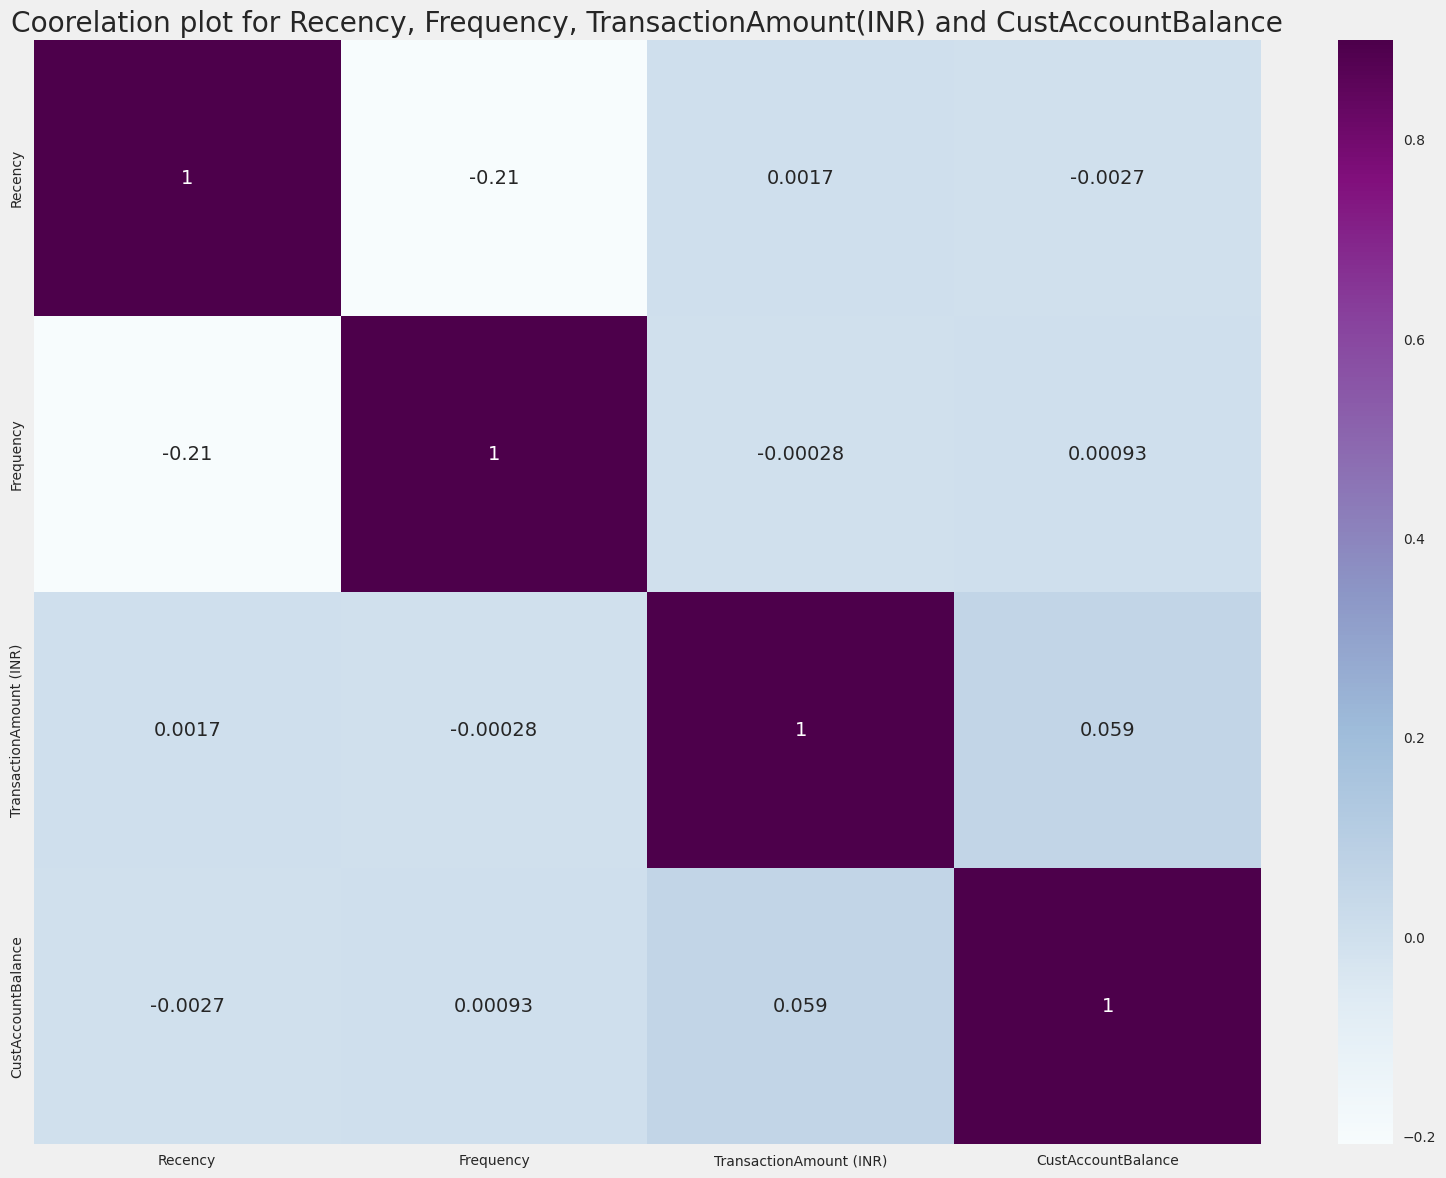

In [145]:
#Coorelation between all 5 variables:
plt.figure(figsize=(16,12))
correlation=RFM_df[['Recency','Frequency','TransactionAmount (INR)','CustAccountBalance']].corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.9,
    cmap='BuPu',
    annot=True,
    cbar=True)
plt.title('Coorelation plot for Recency, Frequency, TransactionAmount(INR) and CustAccountBalance')
plt.tight_layout()

#### The highest correlation exists between frequency and recency. This may be due to some customers who are highly active and do transactions more frequently

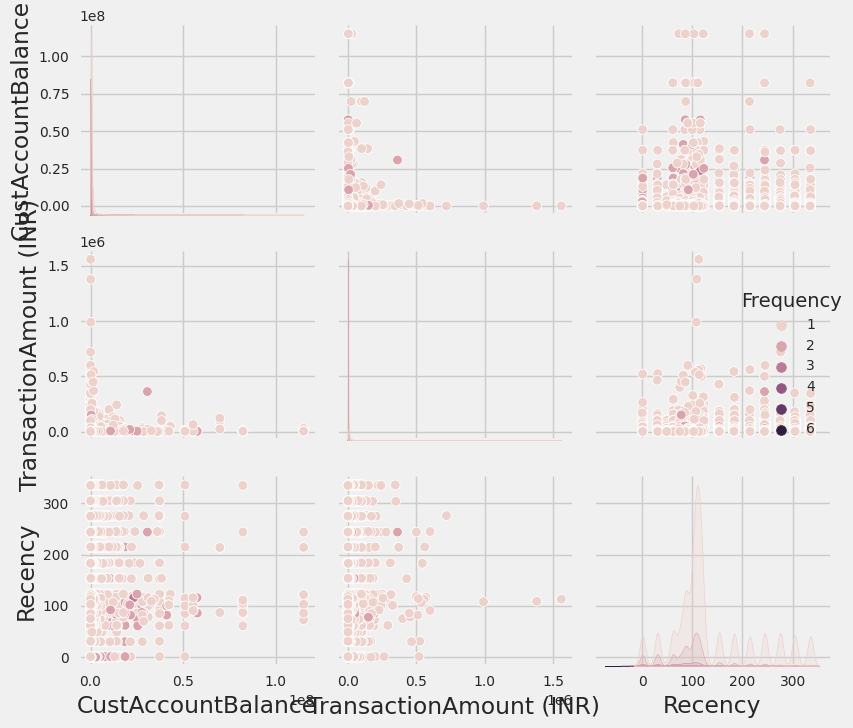

In [146]:
sns.pairplot(RFM_df,hue='Frequency')
plt.tight_layout()

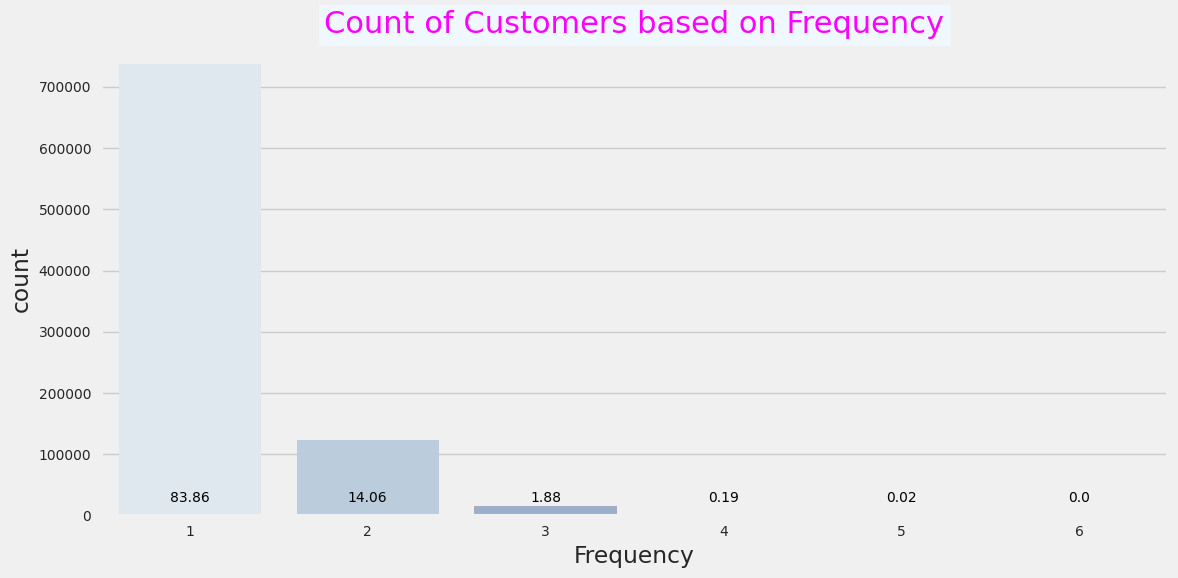

In [147]:
plt.figure(figsize=(12,6))
freq_chart=sns.countplot(x='Frequency',data=RFM_df,palette='BuPu', order = RFM_df['Frequency'].value_counts().index)
plt.title("Count of Customers based on Frequency",
          fontsize='22',
          backgroundcolor='AliceBlue',
          color='magenta')
# Add data labels in the middle of each bar
for bar in freq_chart.patches:
    yval = round((bar.get_height()/RFM_df.shape[0])*100,2)
    xval = bar.get_x() + bar.get_width() / 2

    freq_chart.annotate(
        f'{yval}',
        (xval, yval),
        ha='center',
        xytext=(0, 10),  # Adjust the vertical position of the label
        textcoords='offset points',
        fontsize=10,
        color='black'  # You can customize the color of the label
    )
plt.tight_layout()

#### Most of the customers have done transactions only once. About only 16.14% of customers are repeat customers. This insight might help the bank to provide incentives to non frequent customers and encourage them to carryout transactions through their bank account.  

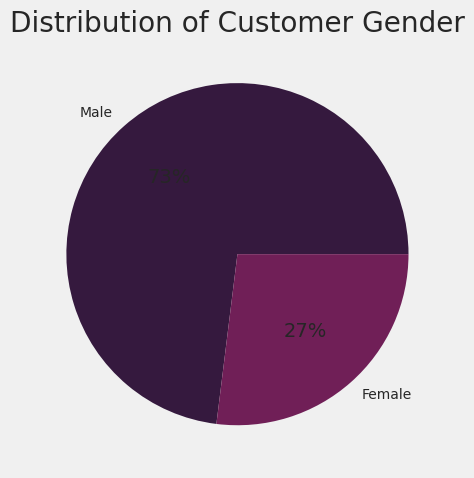

In [148]:
plt.figure(figsize=(8,5))
palette = sns.color_palette('rocket')
plt.pie(RFM_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette,labels=['Male','Female'])
plt.title("Distribution of Customer Gender")
plt.tight_layout()

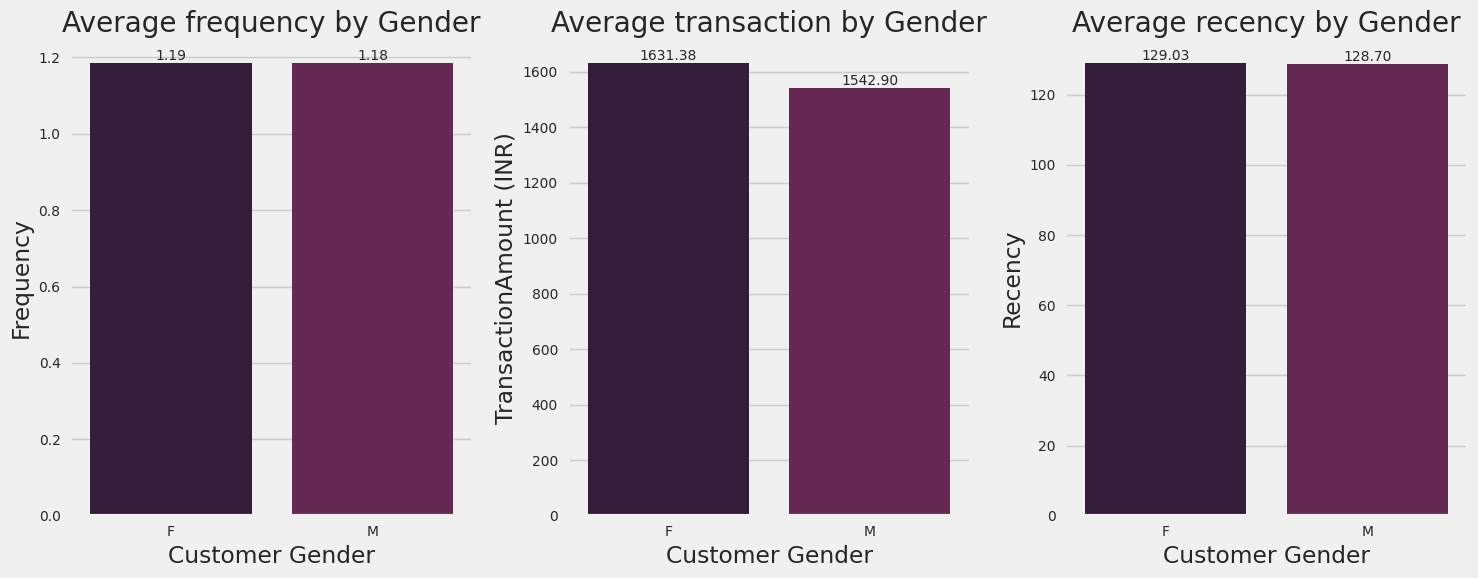

In [149]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,6))
palette = sns.color_palette('rocket')
# Calculate average frequency by gender
average_frequency = RFM_df.groupby('CustGender')['Frequency'].mean().reset_index()
barplot = sns.barplot(x='CustGender', y='Frequency', data=average_frequency,palette=palette, ax=ax[0],ci=None)
# Add data labels to each bar
for p in barplot.patches:
    x_val = p.get_x() + p.get_width() / 2
    y_val = p.get_height()
    ax[0].annotate(f'{y_val:.2f}', (x_val, y_val), ha='center', va='bottom', fontsize=10)
ax[0].set_xlabel('Customer Gender')
ax[0].set_title('Average frequency by Gender')
#Calculate average transaction amount by gender
average_transaction = RFM_df.groupby('CustGender')['TransactionAmount (INR)'].mean().reset_index()
barplot = sns.barplot(x='CustGender', y='TransactionAmount (INR)', data=average_transaction,palette=palette, ax=ax[1],ci=None)
# Add data labels to each bar
for p in barplot.patches:
    x_val = p.get_x() + p.get_width() / 2
    y_val = p.get_height()
    ax[1].annotate(f'{y_val:.2f}', (x_val, y_val), ha='center', va='bottom', fontsize=10)
ax[1].set_xlabel('Customer Gender')
ax[1].set_title('Average transaction by Gender')
#Calculate average recency amount by gender
average_recency = RFM_df.groupby('CustGender')['Recency'].mean().reset_index()
barplot = sns.barplot(x='CustGender', y='Recency', data=average_recency,palette=palette, ax=ax[2],ci=None)
# Add data labels to each bar
for p in barplot.patches:
    x_val = p.get_x() + p.get_width() / 2
    y_val = p.get_height()
    ax[2].annotate(f'{y_val:.2f}', (x_val, y_val), ha='center', va='bottom', fontsize=10)
ax[2].set_xlabel('Customer Gender')
ax[2].set_title('Average recency by Gender')
plt.tight_layout()

#### The Behaviour among male and female customers is almost similar. So no need to add gender column while clustering

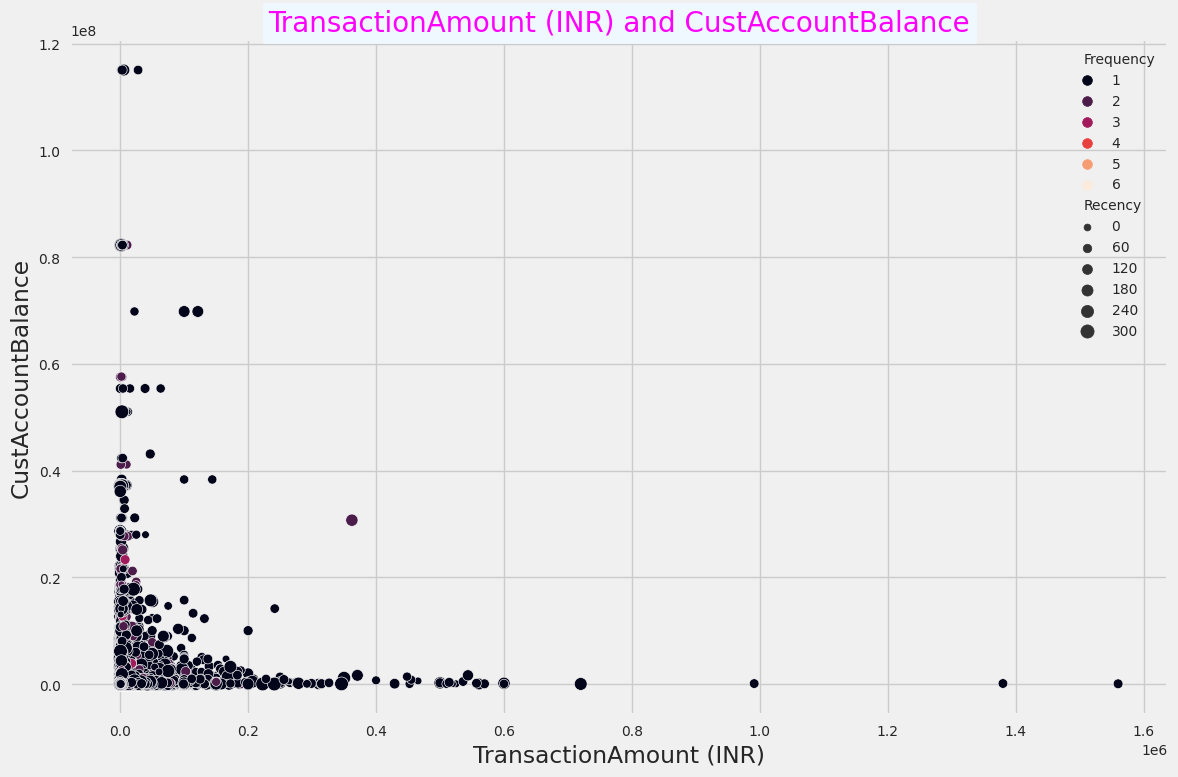

In [150]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=RFM_df,palette='rocket',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')
plt.tight_layout()

#### From graph it can be infered that customers having high account balance are not frequently carrying out transaction.The customers who are frequently doing transactions are the one who makes comparitively little money tranfer and their account balance is also comparitively less.

In [153]:
RFM_df=RFM_df.sort_values(by='TransactionDate')
month_grpby=RFM_df[['Frequency','CustAccountBalance','TransactionAmount (INR)','Recency','TransactionDate']].groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()
print(month_grpby.shape)
month_grpby

(12, 4)


,Frequency,CustAccountBalance,TransactionAmount (INR),Recency
TransactionDate,,,,
2016-01-31,1.006585,107947.871676,1444.010905,335.474139
2016-02-29,1.020555,105557.367136,1497.177796,304.477186
2016-03-31,1.033751,110273.404612,1639.577776,275.435800
2016-04-30,1.052543,114699.426004,1729.241566,244.433849
2016-05-31,1.065026,108158.930901,1601.648970,214.492405
2016-06-30,1.077853,101657.959402,1660.203353,183.575876
2016-07-31,1.097903,99220.980099,1562.050943,153.561622
2016-08-31,1.178053,120848.751624,1571.407598,110.533256
2016-09-30,1.275520,119405.975500,1535.132090,84.185297


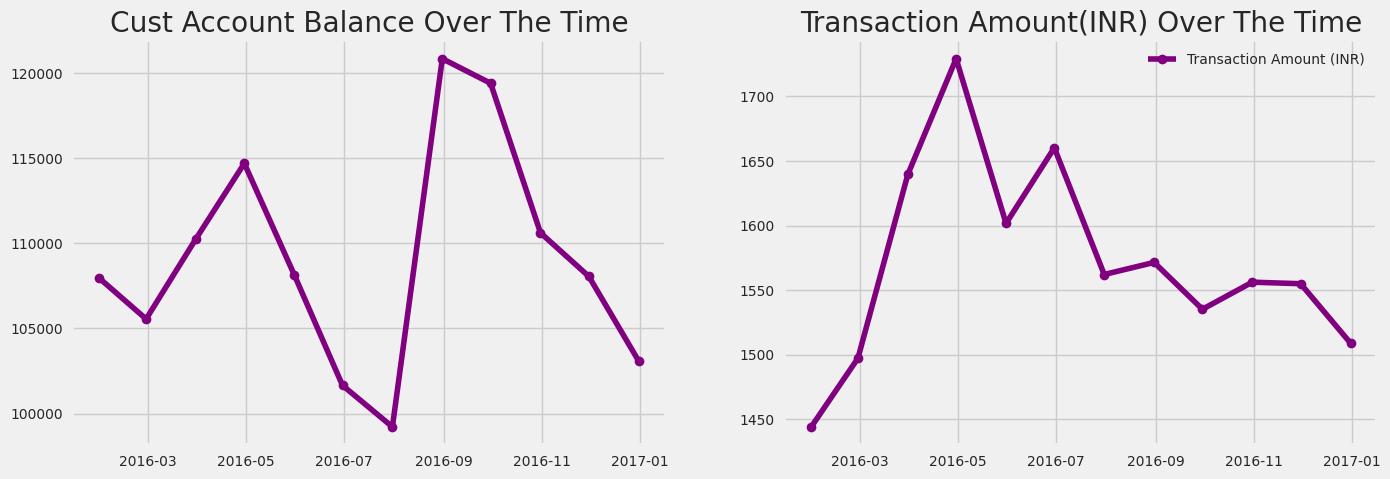

In [154]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(month_grpby.index,month_grpby['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(month_grpby.index,month_grpby['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend();

#### There is a specific trend being observed here on montly basis. The transaction amount hiked in month of may. This is because of people travel a lot in this month because childeren would have summer break. The customer balance and transaction decreased in winter because people pay off their many yearly bills.  

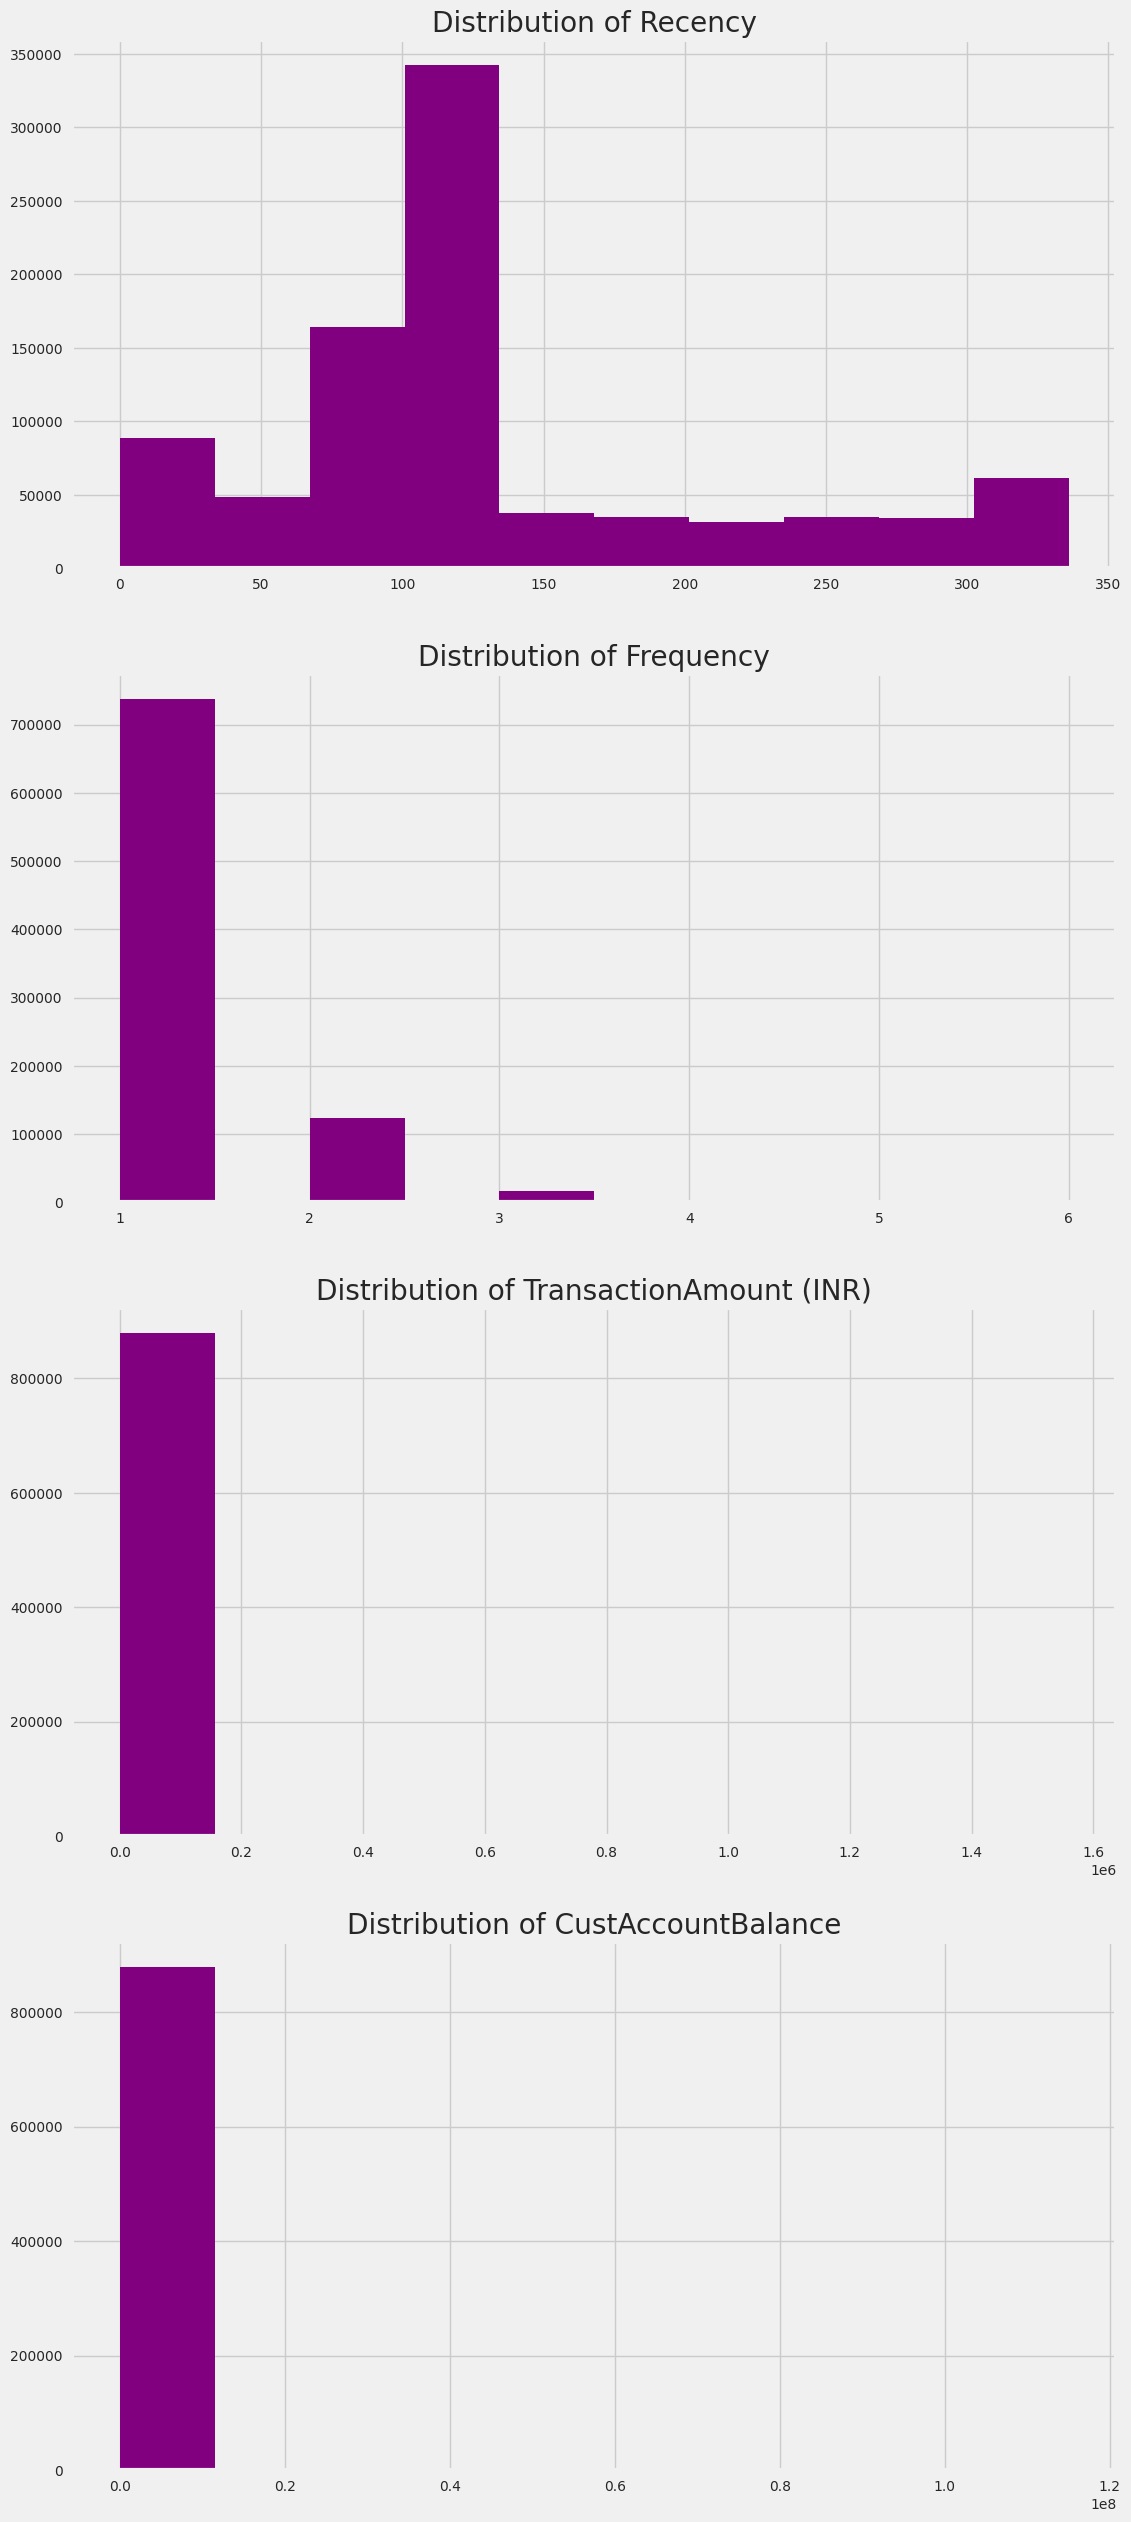

In [155]:
cols = ['Recency','Frequency','TransactionAmount (INR)','CustAccountBalance']
palette_color = sns.color_palette('rocket')
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(12,30))
for i,col in enumerate(cols):
    ax[i].hist(x=RFM_df[col],color='purple')
    ax[i].set_title(f"Distribution of {col}")
    


#### The distribution plot shows that all 5 features are not distributed normally and except frequency each feature is having a skewed distribution

In [156]:
# Logarithmic transformation for Recency, Frequency and Monetary features.
# Adding delta(0.05) component for zero and negative values to handle infinite numbers generated during log transformation as Log(0)=undefined
df_log_transform = pd.DataFrame()
df_log_transform['TransactionAmount (INR)'] = np.log(RFM_df['TransactionAmount (INR)']+0.05)
df_log_transform['CustAccountBalance'] = np.log(RFM_df['CustAccountBalance']+0.05)
df_log_transform['Recency'] =  np.log(RFM_df['Recency']-15.11005)
df_log_transform['Frequency'] =  np.log(RFM_df['Frequency']+14.11005)

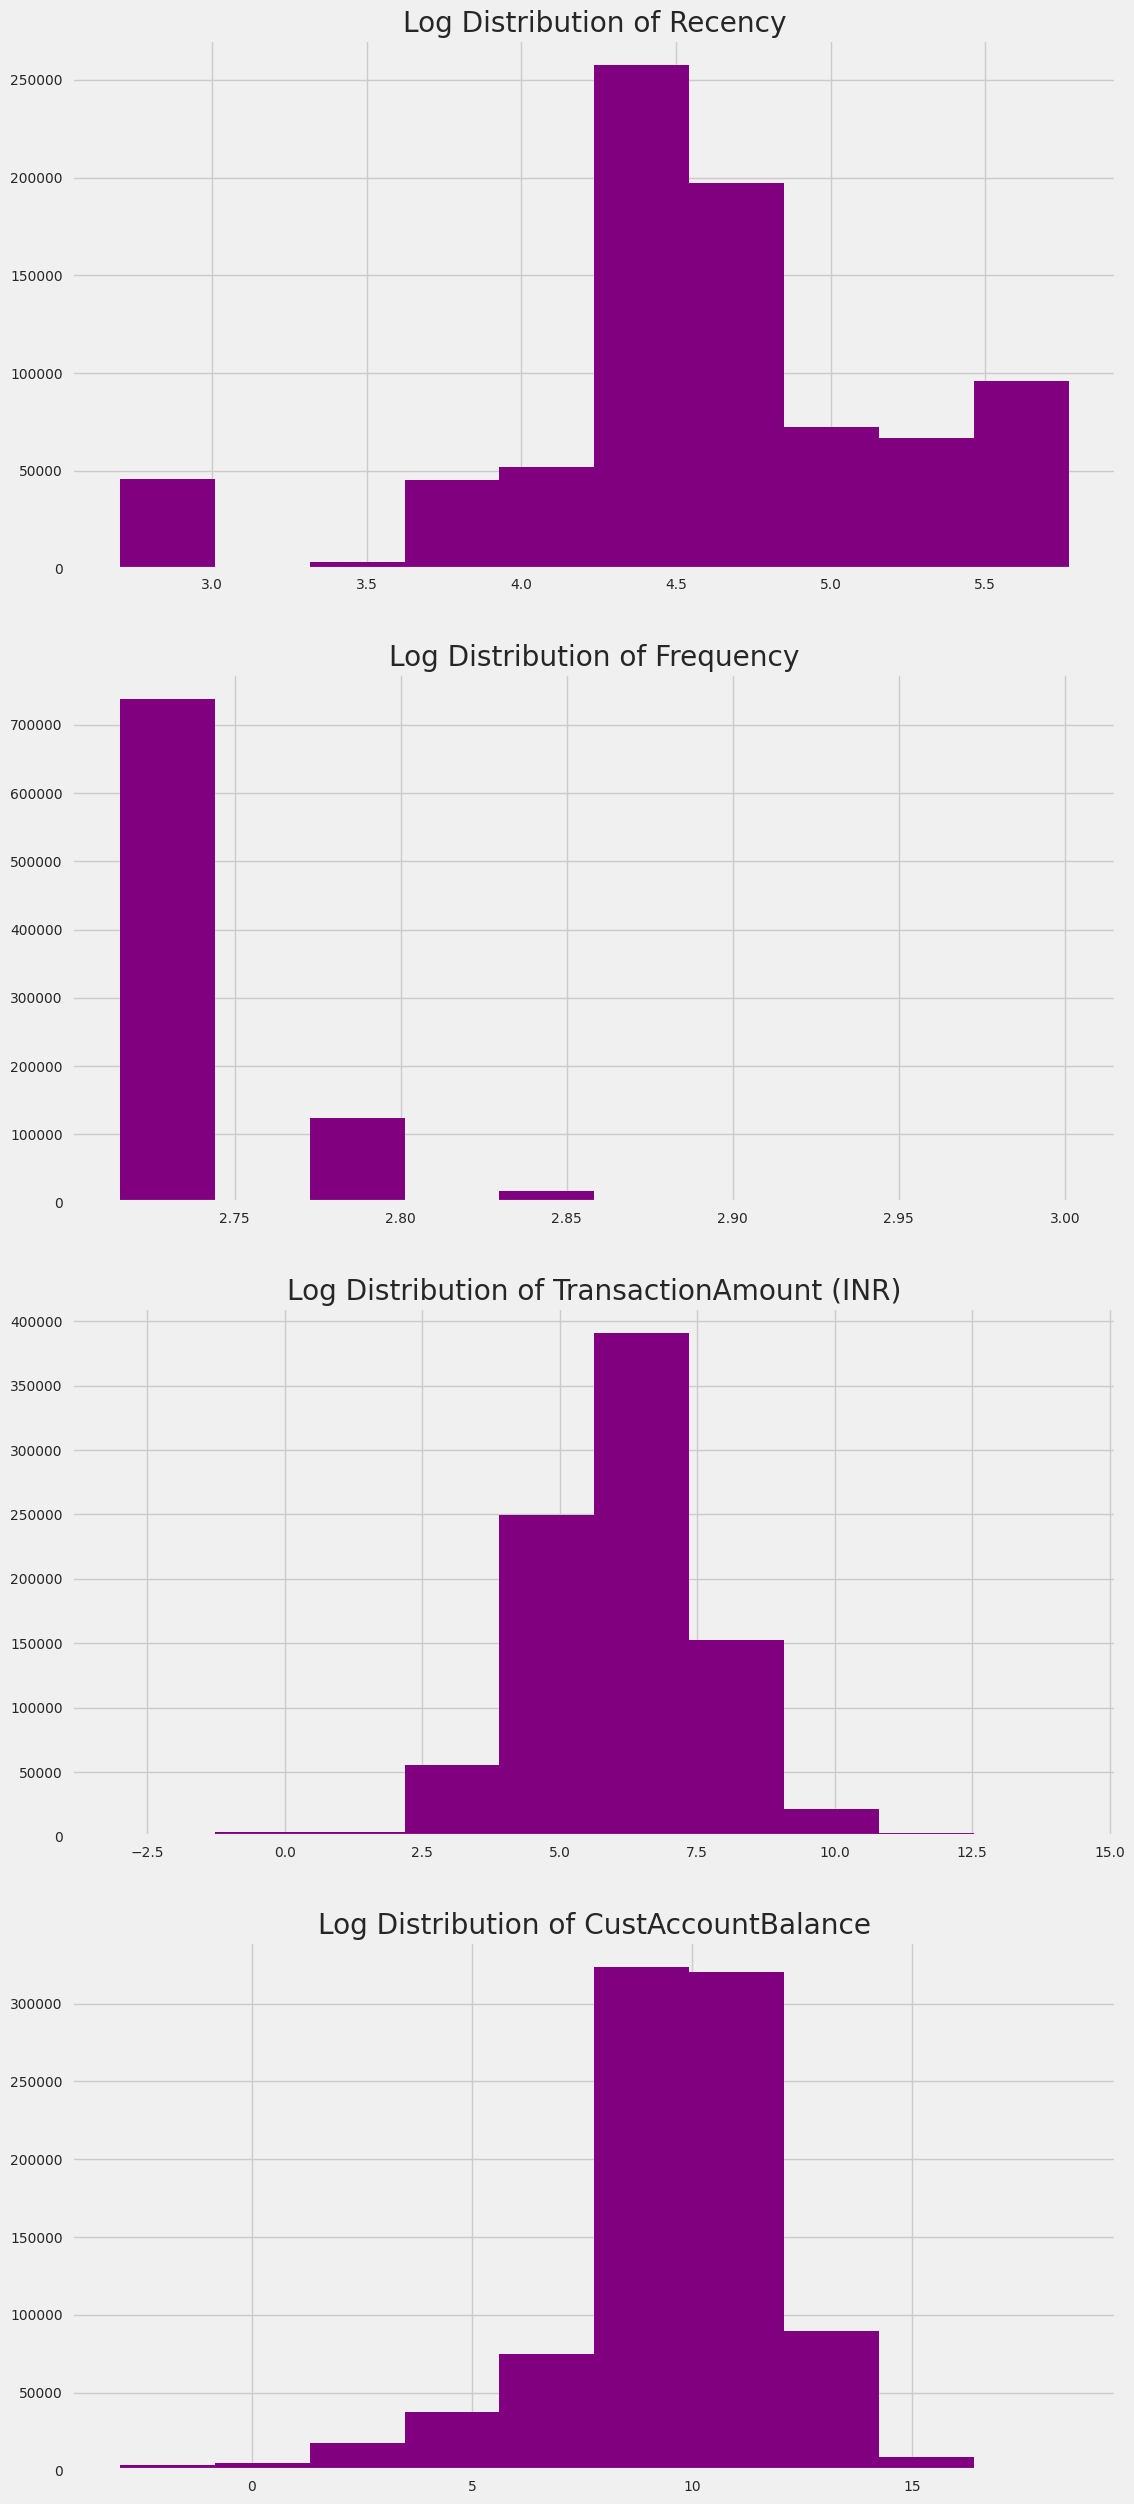

In [157]:
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(12,30))
for i,col in enumerate(cols):
    ax[i].hist(x=df_log_transform[col],color='purple')
    ax[i].set_title(f"Log Distribution of {col}")

#### Normalized skewed variables

### 1.6 Feature Engineering

In [158]:
df_log_transform = df_log_transform.reset_index(drop=True)

In [159]:
df_log_transform.head()

,TransactionAmount (INR),CustAccountBalance,Recency,Frequency
0,5.517654,8.278540,5.771098,2.71536
1,1.619388,5.327633,5.771098,2.71536
2,8.095004,9.028519,5.771098,2.71536
3,5.560874,9.513053,5.771098,2.71536
4,6.397013,8.070956,5.771098,2.71536


In [160]:
# feature scaling
df_log_scaled=StandardScaler().fit_transform(df_log_transform)
df_log_scaled=pd.DataFrame(df_log_scaled,columns=df_log_transform.columns)
df_log_scaled.head()

,TransactionAmount (INR),CustAccountBalance,Recency,Frequency
0,-0.377002,-0.525928,1.761966,-0.414128
1,-2.838262,-1.728815,1.761966,-0.414128
2,1.250267,-0.220212,1.761966,-0.414128
3,-0.349714,-0.022699,1.761966,-0.414128
4,0.178201,-0.610546,1.761966,-0.414128


#### Performing kmeans over 100000 rows

In [161]:
df_log_scaled=df_log_scaled.sample(n=100000,random_state=50).reset_index(drop=True).dropna()
df_log_scaled.shape

(95208, 4)

### 1.7 Model Building

In [162]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":250, "random_state":50}

inertia = []
silhouette_coefficient = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(df_log_scaled)
    inertia.append(kmeans.inertia_)
    score=silhouette_score(df_log_scaled, kmeans.labels_)
    silhouette_coefficient.append(score)

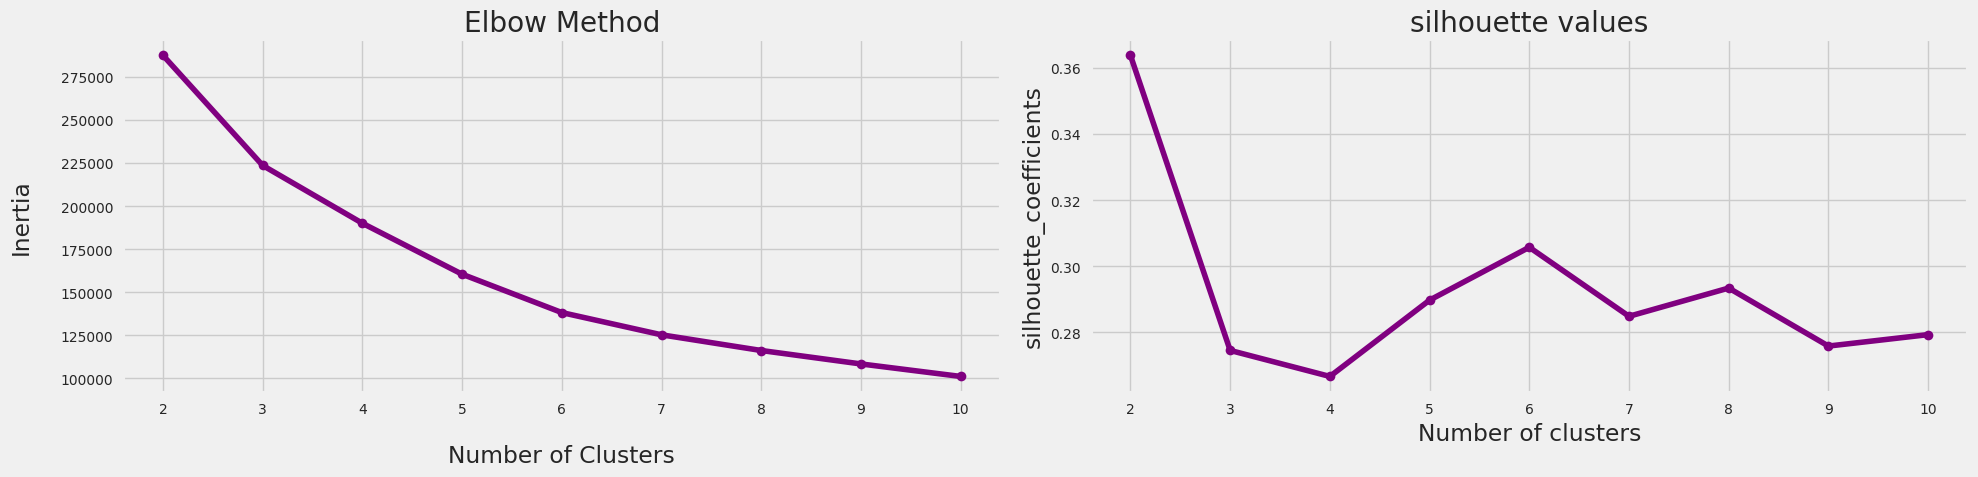

In [165]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
# kl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
#ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,11), silhouette_coefficient,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

#### The elbow method shows that the optimal number of cluster is 5.

In [166]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
kmeans.fit(df_log_scaled)
df_log_scaled['Label']=kmeans.labels_
df_log_scaled.head()

,TransactionAmount (INR),CustAccountBalance,Recency,Frequency,Label
0,0.523640,-0.065198,-0.688662,1.848916,4
1,-1.088310,0.355798,-2.810102,1.848916,2
2,-0.680299,0.311419,0.797360,-0.414128,3
3,0.885677,1.398464,0.806203,-0.414128,0
4,0.500702,0.376694,-1.101961,-0.414128,0


In [168]:
attributes = df_log_scaled.columns[:4]
colors=['orange','green','red','blue','magenta']
cluster=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']

fig = go.Figure()
for index in range(0,5):
    fig.add_trace(go.Scatterpolar(
    r=[np.mean(df_log_scaled.loc[df_log_scaled.Label == index, attribute]) for attribute in attributes],
    theta=attributes,
    fill='toself',
    fillcolor=colors[index],
    opacity=0.4,
    name=cluster[index]
))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

#### Cluster 4 has high frequency. Such customers are loyal customers who carryout transactions frequently. They should be provided incentives for this behaviour.
#### Cluster 5 are the customers who are having higher transaction amount, recency, account balance but lesser frequency. Those customers should be encouraged to carryout more transactions by providing them offers like cashback for frequently doing transaction through the bank account.
#### While customers in cluster 1, 2 and 3 are more sort of churned customers. They should be provided offers and discount coupons to encourage transactions from their bank account. Moreover marketing team can focus on contacting these customers and retaining them.  

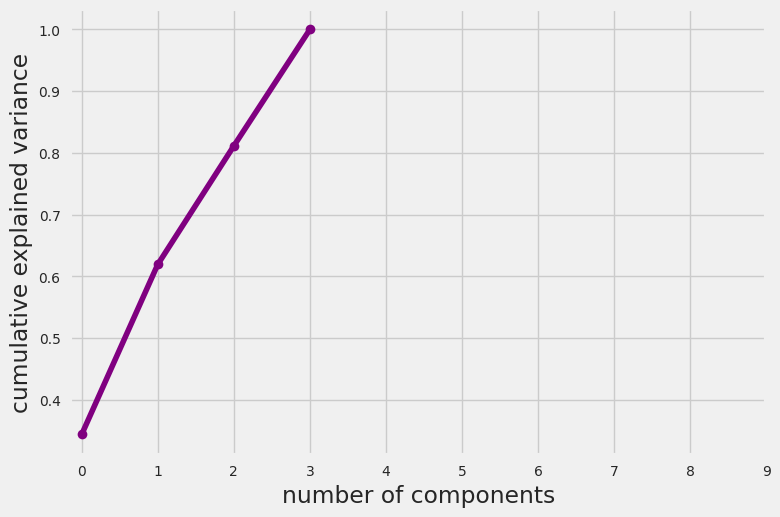

In [169]:
# here we want to check how many component we need to explain 90%  of the variance
plt.style.use("fivethirtyeight")
pca = PCA().fit(df_log_scaled.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# x tickes
plt.xticks(np.arange(0, 10, 1))
plt.show();

#### Thus the 90% of varaince can be explained by 3 components which alings with the 3 major group of customers that we discussed earlier.

In [170]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(df_log_scaled.iloc[:,:-1])

inertia = []
silhouette = []


for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=50)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

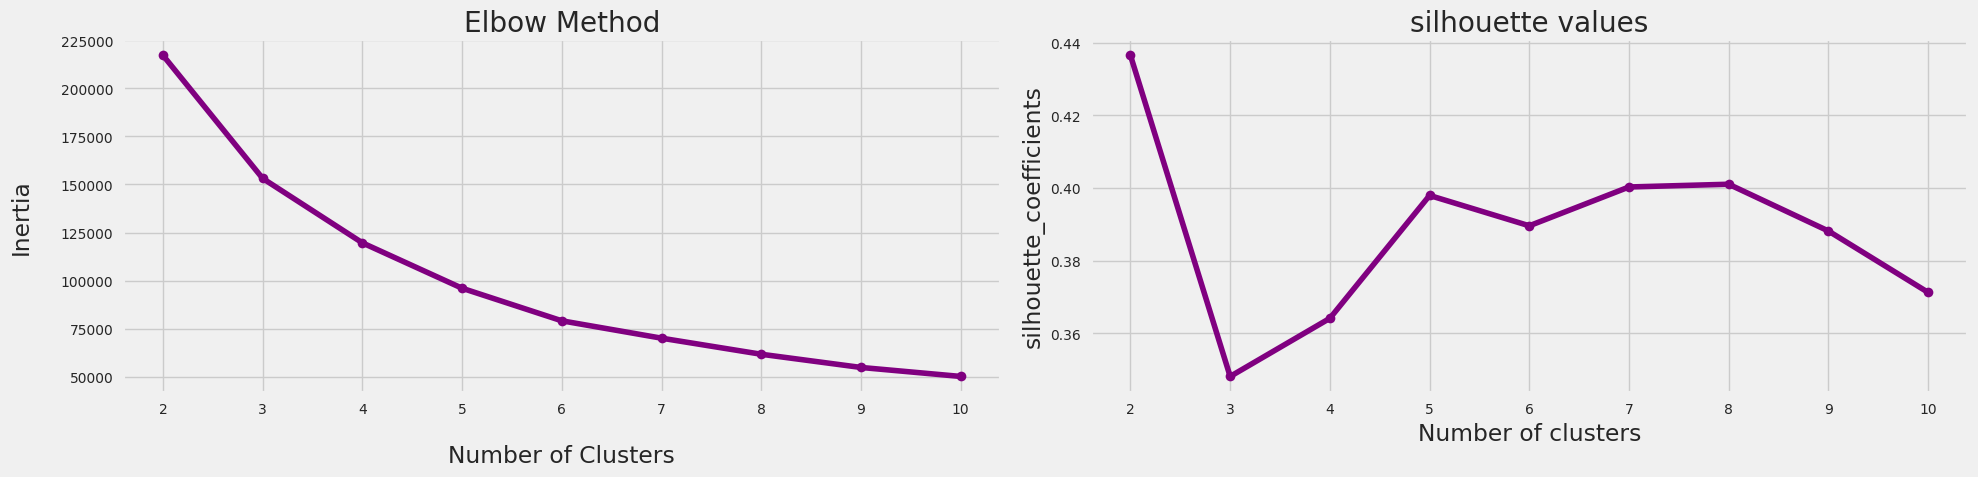

In [172]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
#Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
#ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

In [180]:
PCA_kmeans = KMeans(n_clusters=3 , **kmeans_set)    
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = PCA_kmeans.labels_
pca_df.head()

,PC1,PC2,PC3,label
0,-1.420807,1.038359,0.886218,1
1,-1.518997,3.098851,-0.078258,1
2,0.675515,-0.550290,0.305577,0
3,-0.801870,-1.642903,-0.123158,2
4,-0.673832,0.265683,-1.113303,2


In [181]:
attributes = pca_df.columns[:3]
colors=['purple','yellow','red']
cluster=['Cluster 1','Cluster 2','Cluster 3']

fig = go.Figure()
for index in range(0,3):
    fig.add_trace(go.Scatterpolar(
    r=[np.mean(pca_df.loc[pca_df.label == index, attribute]) for attribute in attributes],
    theta=attributes,
    fill='toself',
    fillcolor=colors[index],
    opacity=0.4,
    name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),showlegend=True,
                  title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()

#### To comclude there are 3 main types of customers that bank need to focus. This finding is also confirmed by PCA on k-means clusters.